In [1]:
import yfinance as yf 
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler # LSTM is sensitive to the scale of the data so using MinMaxScaler
from tensorflow import keras
import pandas as pd, numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
data = yf.download('TSLA', period='10y')

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date', ylabel='Close'>

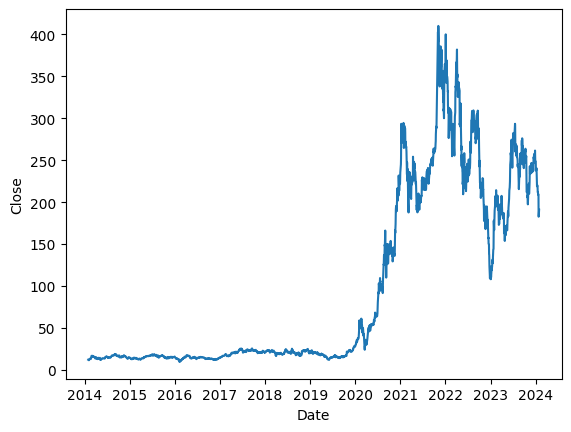

In [3]:
sns.lineplot(x=data.index, y=data.Close)

In [4]:
mms = MinMaxScaler(feature_range=(0, 1))
dataClose = mms.fit_transform(np.array(data.Close).reshape(-1, 1))
dataClose

array([[0.00652194],
       [0.00628384],
       [0.00556788],
       ...,
       [0.43220645],
       [0.43375492],
       [0.4529361 ]])

In [5]:
trainSize = int(len(dataClose) * 0.70)
testSize = len(dataClose) - trainSize

train = dataClose[0:trainSize, :]
test = dataClose[trainSize:len(dataClose), : 1]
train.shape, test.shape

((1761, 1), (755, 1))

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [8]:
X_train.shape, y_train.shape

((1660, 100), (1660,))

In [9]:
X_test.shape, y_test.shape

((654, 100), (654,))

In [10]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
X_train

array([[[0.00652194],
        [0.00628384],
        [0.00556788],
        ...,
        [0.01400627],
        [0.01430598],
        [0.0155764 ]],

       [[0.00628384],
        [0.00556788],
        [0.00583761],
        ...,
        [0.01430598],
        [0.0155764 ],
        [0.01479051]],

       [[0.00556788],
        [0.00583761],
        [0.00511998],
        ...,
        [0.0155764 ],
        [0.01479051],
        [0.01552146]],

       ...,

       [[0.34461727],
        [0.39093856],
        [0.37156588],
        ...,
        [0.67918106],
        [0.68409293],
        [0.67954737]],

       [[0.39093856],
        [0.37156588],
        [0.34852179],
        ...,
        [0.68409293],
        [0.67954737],
        [0.68092099]],

       [[0.37156588],
        [0.34852179],
        [0.31491306],
        ...,
        [0.67954737],
        [0.68092099],
        [0.70935984]]])

In [12]:
X_train.shape, X_test.shape

((1660, 100, 1), (654, 100, 1))

In [13]:
model=keras.models.Sequential()
model.add(keras.layers.LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(keras.layers.LSTM(50,return_sequences=True))
model.add(keras.layers.LSTM(50))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.fit(x=X_train, y=y_train,batch_size=64, epochs=100, verbose=True)

Epoch 1/100
26/26 [==============================] - 19s 244ms/step - loss: 0.0032
Epoch 2/100
26/26 [==============================] - 7s 253ms/step - loss: 3.2711e-04
Epoch 3/100
26/26 [==============================] - 7s 268ms/step - loss: 2.7359e-04
Epoch 4/100
26/26 [==============================] - 6s 249ms/step - loss: 2.3163e-04
Epoch 5/100
26/26 [==============================] - 6s 244ms/step - loss: 2.7236e-04
Epoch 6/100
26/26 [==============================] - 6s 247ms/step - loss: 2.2579e-04
Epoch 7/100
26/26 [==============================] - 7s 257ms/step - loss: 2.0721e-04
Epoch 8/100
26/26 [==============================] - 6s 249ms/step - loss: 1.9803e-04
Epoch 9/100
26/26 [==============================] - 6s 218ms/step - loss: 1.9373e-04
Epoch 10/100
26/26 [==============================] - 6s 225ms/step - loss: 2.6632e-04
Epoch 11/100
26/26 [==============================] - 6s 226ms/step - loss: 1.8164e-04
Epoch 12/100
26/26 [==============================] - 5

In [18]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

21/21 [==============================] - 1s 56ms/step


In [19]:
train_predict=mms.inverse_transform(train_pred)
test_predict=mms.inverse_transform(test_pred)

In [66]:
import math
from sklearn.metrics import mean_squared_error
MSE = math.sqrt(mean_squared_error(y_train,train_predict))
round(MSE, 2)

54.29

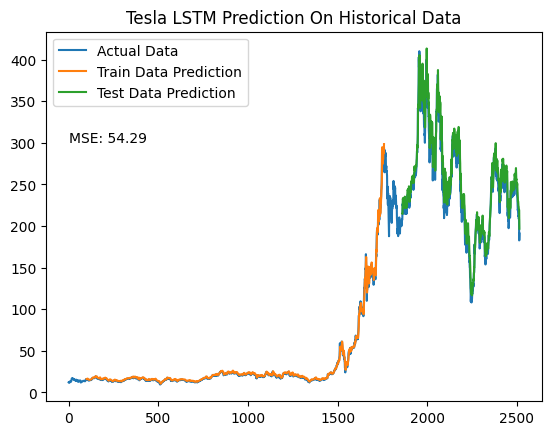

In [73]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(dataClose)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataClose)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataClose)-1, :] = test_predict
# plot baseline and predictions
plt.plot(mms.inverse_transform(dataClose), label='Actual Data')
plt.plot(trainPredictPlot, label='Train Data Prediction')
plt.plot(testPredictPlot, label = 'Test Data Prediction')
plt.legend()
plt.title('Tesla LSTM Prediction On Historical Data')
plt.text(1, 300, s=f'MSE: {float(round(MSE, 2))}')
plt.show()

In [27]:
test.shape

(755, 1)

In [36]:
x_input=test[655:].reshape(1,-1)
x_input.shape

(1, 100)

In [37]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [38]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.4776407]
101
1 day input [0.60418791 0.59672021 0.65935879 0.64412378 0.65366438 0.66550283
 0.66138188 0.63862914 0.64167616 0.63191072 0.61470258 0.58767908
 0.59294892 0.58578092 0.57673979 0.59142541 0.60101601 0.60446264
 0.59180003 0.62833923 0.62556691 0.62676576 0.62461791 0.63448319
 0.63290972 0.62261982 0.60326379 0.61025694 0.61257969 0.58218444
 0.5258147  0.50553459 0.50575936 0.5168485  0.50660852 0.48997481
 0.49382106 0.46899538 0.47768686 0.48972508 0.5218186  0.52544008
 0.52371677 0.53098462 0.53080981 0.50051448 0.51217805 0.53480591
 0.56902237 0.58258406 0.5594817  0.56125498 0.5645018  0.57848807
 0.56103021 0.56412715 0.56570062 0.59227457 0.58583088 0.57569083
 0.57256889 0.56445184 0.57229415 0.57391755 0.58208455 0.58508161
 0.57484167 0.56802332 0.57371774 0.60308898 0.60920797 0.60566145
 0.61849887 0.59332354 0.61170553 0.60681031 0.61697533 0.62903855
 0.60840874 0.59667025 0.5965204  0.5716198  0.57032107 0.56922217
 0.57661491 0.56290337 0.56035586 

In [42]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [43]:
import matplotlib.pyplot as plt

In [40]:
len(dataClose)

2516

Text(0.5, 1.0, 'Tesla LSTM Future Prediction')

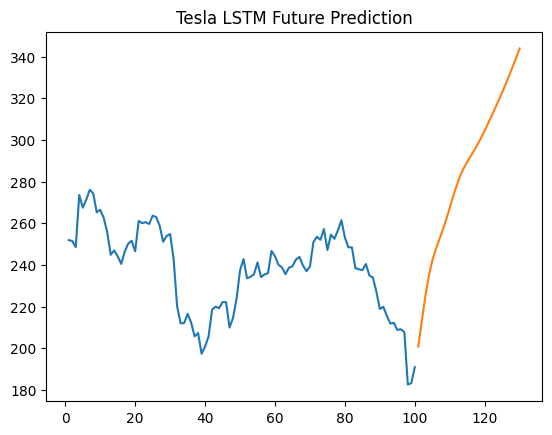

In [72]:
plt.plot(day_new,mms.inverse_transform(dataClose[2416:]))
plt.plot(day_pred,mms.inverse_transform(lst_output))
plt.title('Tesla LSTM Future Prediction')

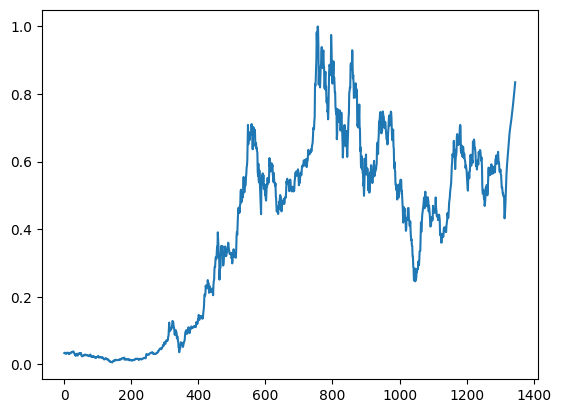

In [45]:
df3=dataClose.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [46]:
df3=mms.inverse_transform(df3).tolist()

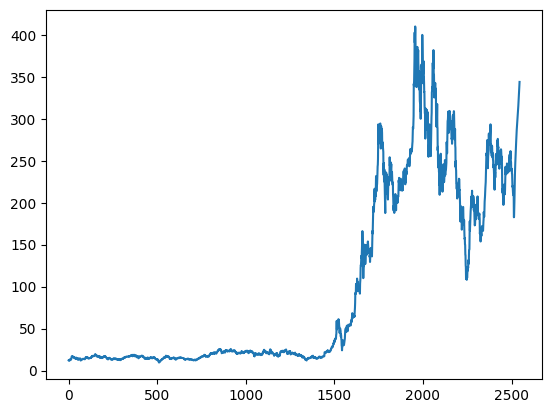

In [47]:
plt.plot(df3)